# 主題：政治新聞資料分析
- 組員：王冠人、萬俊彥、廖品琪
- 時間：2019/01/29

## 研究目標
考量臺灣社會政治冷感的現狀，提供一個較為客觀的資料統整，藉由日常生活中的事件觀察政治人物的網路聲量變化，作為一種參與政治的方式。

## 研究方法
1. 爬蟲搜尋網路新聞
2. 進行資料清理及資料分析
4. 視覺化呈現研究結果

## 研究內容及結果

# Part I 爬蟲

- [新頭殼新聞爬蟲](https://github.com/MiccWan/Political-News-Analysis/blob/master/crawler/new_talk_crawler.ipynb)
- [自由時報新聞爬蟲](https://github.com/MiccWan/Political-News-Analysis/blob/master/crawler/liberty_times_crawler.ipynb)

#  Part II 資料清洗及分析

In [1]:
import os
import pickle
import jieba
import operator
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from datetime import datetime
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from modules import *

font_path = '../tools/msjh.ttc'
font = font_manager.FontProperties(fname='../tools/msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)

### 載入新聞資料

In [2]:
with open('../crawler/data/new_talk.pkl', 'rb') as f:
    data = pickle.load(f)
    
data = data[::-1]
contents = [news['content'] for news in data]

### 使用 coshow 找出新詞 -> 自定義辭典

In [3]:
get_coshow(contents[:1000])[:10]

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\R\AppData\Local\Temp\jieba.cache
Loading model cost 1.326 seconds.
Prefix dict has been built succesfully.


[('68', 1002),
 ('蔡英文', 855),
 ('民進黨', 621),
 ('柯文哲', 579),
 ('對於', 569),
 ('台北市長', 385),
 ('沒有', 309),
 ('）日', 276),
 ('長參選人', 255),
 ('都是', 251)]

### 設定繁體中文斷詞、載入自訂辭典、stopwords

In [4]:
jieba.set_dictionary('../jieba_data/dict.txt.big')
jieba.load_userdict('../jieba_data/userdict.txt')
stopwords = []
with open('../jieba_data/stopwords.txt', 'r', encoding='UTF-8') as file:
    for each in file.readlines():
        stopwords.append(each.strip())
    stopwords.append(' ')

Building prefix dict from C:\Users\R\Desktop\political-news-hw0\jieba_data\dict.txt.big ...
Dumping model to file cache C:\Users\R\AppData\Local\Temp\jieba.u0e8910c9fd4f5f07b900bed32ed44d87.cache
Loading model cost 2.230 seconds.
Prefix dict has been built succesfully.


In [5]:
# add cutted dict to each news
for i in range(len(data)):
    current_content = data[i]['content']
    current_cutted = jieba.lcut(remove_punctuation(current_content))
    data[i]['cutted_dict'] = lcut_to_dict(current_cutted)
    

In [6]:
get_coshow(contents[:1000])[:10]

[('68', 1002),
 ('今（', 340),
 ('）日', 335),
 ('都是', 250),
 ('台灣的', 229),
 ('8月', 209),
 ('也是', 207),
 ('（）', 196),
 ('的人', 187),
 ('為了', 177)]

In [7]:
cutted_dict = get_cutted_dict(contents[:1000])
high_freq_pair = first_n_words(cutted_dict, 20)
high_freq_pair

[('台灣', 1762),
 ('中國', 953),
 ('柯文哲', 905),
 ('國民黨', 883),
 ('民進黨', 643),
 ('指出', 585),
 ('媒體', 579),
 ('希望', 547),
 ('蔡英文', 492),
 ('政府', 457),
 ('一個', 439),
 ('政策', 422),
 ('支持', 418),
 ('提供', 408),
 ('國家', 405),
 ('未來', 403),
 ('市長', 390),
 ('選舉', 382),
 ('姚文智', 381),
 ('提出', 371)]

In [8]:
cutted_dict = get_cutted_dict(contents)

In [9]:
# 可能人名
possible_name = first_n_words(cutted_dict, 1000, 3, 3)
possible_name[:10]

[('民進黨', 8678),
 ('柯文哲', 8418),
 ('國民黨', 8187),
 ('韓國瑜', 7944),
 ('陳其邁', 4360),
 ('蔡英文', 4076),
 ('蘇貞昌', 3251),
 ('候選人', 2946),
 ('姚文智', 2528),
 ('賴清德', 2253)]

In [10]:
# 可能事件
possible_events = first_n_words(cutted_dict, 200, 4)
possible_events[:10]

[('台北市長柯文哲', 1572),
 ('總統蔡英文', 1405),
 ('九二共識', 1110),
 ('立委補選', 1096),
 ('時代力量', 1071),
 ('中華民國', 968),
 ('2020', 915),
 ('行政院長賴清德', 874),
 ('轉型正義', 840),
 ('競選總部', 752)]

### 載入人名、事件

In [11]:
names = []
with open('../data/names.txt', 'r', encoding='utf-8-sig') as f:
    names = f.read().split('\n')
    
events = []
with open('../data/events.txt', 'r', encoding='utf-8-sig') as f:
    events = f.read().split('\n')

In [12]:
print(' '.join(names[:5]))
print(' '.join(events[:5]))

柯文哲 韓國瑜 陳其邁 蔡英文 蘇貞昌
九二共識 兩岸關係 轉型正義 立委補選 九合一選舉


### 文字雲

50300


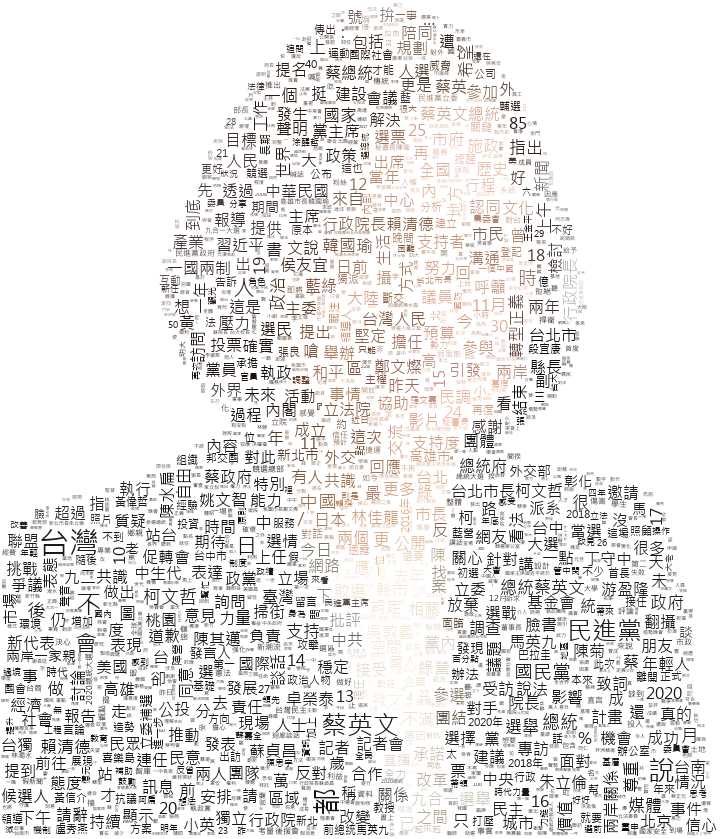

In [15]:
# 蔡英文
ten_wc = get_wordcloud_of_keywords('蔡英文', contents, '../politicians/ten.png')
# ten_wc.to_file('politicians/tenwc.png')
ten_wc.to_image()

In [16]:
news_containing_ten = news_containing_keyword('蔡英文', contents)
ten_dict = get_cutted_dict(news_containing_ten)
first_n_words(ten_dict, 5)

[('台灣', 5319), ('蔡英文', 4076), ('民進黨', 3742), ('中國', 2273), ('國民黨', 2074)]

44332


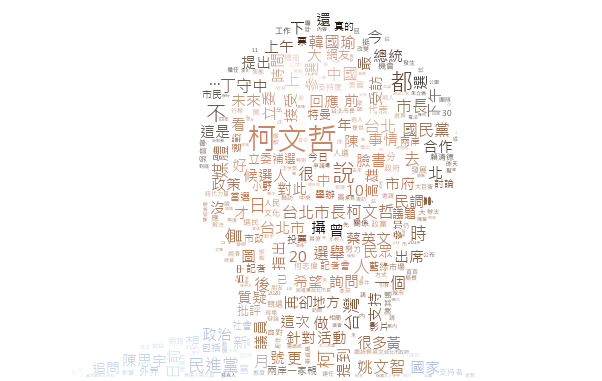

In [17]:
# 柯文哲
kp_wc = get_wordcloud_of_keywords('柯文哲', contents, image_path='../politicians/kp.png')
# kp_wc.to_file('politicians/kpwc.png')
kp_wc.to_image()

In [18]:
news_containing_kp = news_containing_keyword('柯文哲', contents)
kp_dict = get_cutted_dict(news_containing_kp)
first_n_words(kp_dict, 5)

[('柯文哲', 8418), ('台灣', 2522), ('媒體', 2343), ('民進黨', 2161), ('姚文智', 1841)]

19331


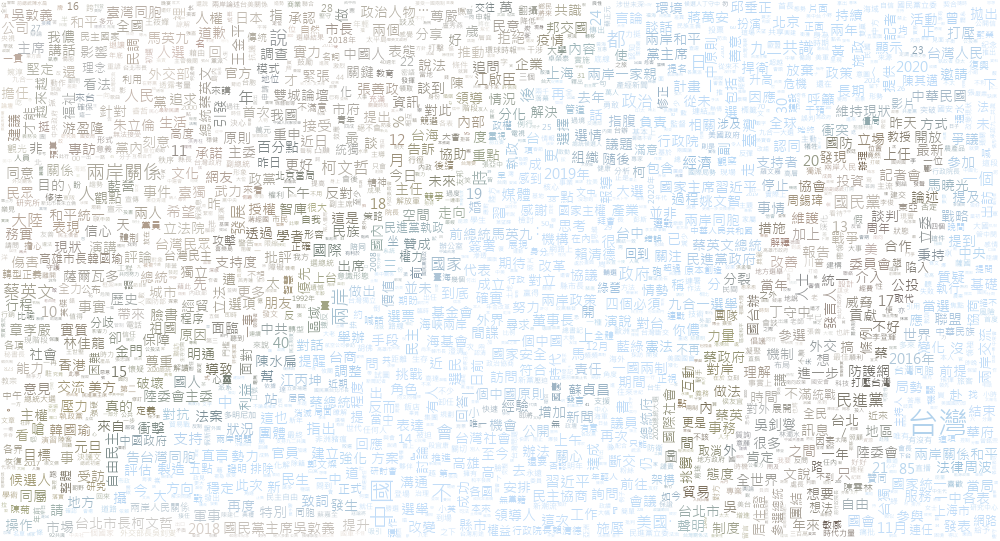

In [28]:
#兩岸關係的示範圖
twoside_wc = get_wordcloud_of_keywords('兩岸關係', contents, '../politicians/twoside.jpg')
twoside_wc.to_image()

### get date

In [19]:
date_list = [news['date'] for news in data]
all_date = sorted(list(set(date_list)))
aall_date = [date[5:] for date in all_date][::-1]
date_index = [date_list.index(each_date) for each_date in all_date]
date_index.append(len(date_list)-1)
number_of_news = [date_index[i+1] - date_index[i]-1 for i in range(len(date_index)-1)]
number_of_terms = [sum([sum(data[ni]['cutted_dict'].values()) for ni in range(date_index[i], date_index[i+1])]) for i in range(len(date_index)-1)]

In [20]:
# 每日詞數
wn_by_day = {}
for i in range(len(date_index)-1):
#     print(date_index[i+1])
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict)
#     print(all_date[i])
    wn_by_day[all_date[i]] = current_word_dict

In [21]:
# 每日詞頻
tf_by_day = {}
for i in range(len(date_index)-1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict, divide=number_of_terms[i])
#     print(all_date[i])
    tf_by_day[all_date[i]] = current_word_dict

In [22]:
# 每天出現的字
occur_by_day = {}
for i in range(len(date_index)-1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict, count='occur', divide=number_of_news[i])
#     print(all_date[i])
    occur_by_day[all_date[i]] = current_word_dict

In [23]:
df = pd.DataFrame(wn_by_day)
df = df.fillna(0)

df_tf = pd.DataFrame(tf_by_day)
df_tf = df_tf.fillna(0)

df_occur = pd.DataFrame(occur_by_day)
df_occur = df_occur.fillna(0)

### 畫圖

ValueError: x and y must have same first dimension, but have shapes (73,) and (125,)

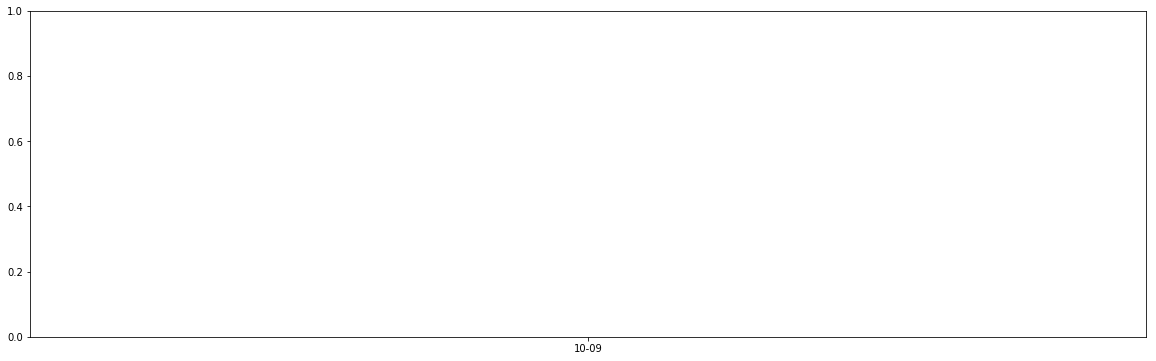

In [40]:
# word times
plt.figure(figsize=(20,6))
plt.plot(aall_date[147:], df.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.show()

ValueError: x and y must have same first dimension, but have shapes (73,) and (125,)

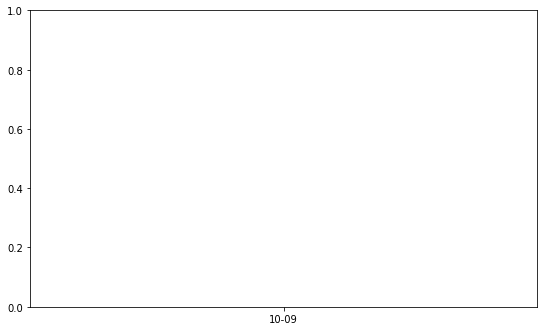

In [29]:
plt.figure(figsize=(20,12))

font = font_manager.FontProperties(fname='../msjh.ttc',
                               weight='bold',
                               style='normal', size=16)

plt.subplot(221)
plt.plot(aall_date[147:], df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('tf')

plt.subplot(222)
plt.plot(aall_date[147:], df_occur.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('df')

plt.subplot(212)
plt.plot(aall_date[147:], df_occur.loc['蔡英文']['2018-11-01':]*df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('tfdf')

plt.show()

In [30]:
def plot_tfdf_of_word(word, df_tf, df_occur, date_from='2018-06-07', date_to='2019-01-22'):
    from_index = df_tf.columns.get_loc(date_from)
    to_index = df_tf.columns.get_loc(date_to)+1
    date_length = to_index-from_index
    date_int = date_length//25
    font = font_manager.FontProperties(fname='../msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)
    
    plt.plot(aall_date[from_index:to_index], 
             df_tf.loc[word][date_from:date_to]*df_occur.loc[word][date_from:date_to], '-o', label=word)
    plt.legend(prop=font)
    plt.xticks(list(range(0, date_length, date_int)), [aall_date[from_index:to_index][i] for i in range(0, date_length, date_int)])

In [31]:
plt.figure(figsize=(20,6))

plot_tfdf_of_word('九二共識', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-01')
plot_tfdf_of_word('蔡英文', df_tf, df_occur, date_from='2018-11-01', date_to='2019-01-01')

plt.grid()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../msjh.ttc'

<Figure size 1440x432 with 1 Axes>

### 大事件被討論的時間區段與聲量

In [32]:
def get_high_tfdf_date(word, df_tf, df_occur):
    tfdf = get_tfdf(word, df_tf, df_occur)
    m = statistics.mean(tfdf)
    s = statistics.stdev(tfdf)
    tfdf_bool = [x > m+s for x in tfdf]
    tfdf_date = {all_date[x[0]]: tfdf[x[0]] for x in list(filter(lambda e: e[1], enumerate(tfdf_bool)))}
    return tfdf_date

def draw_event(event, i, df_tf, df_occur):
    event_date = get_high_tfdf_date(event, df_tf, df_occur)
    date_index = [all_date.index(x) for x in event_date.keys()]
    plt.scatter(date_index, [i for x in date_index], s=[x*100000 for x in list(event_date.values())])

In [33]:
event_high_tfdf_dict = {e: get_high_tfdf_date(e, df_tf, df_occur) for e in events}
event_high_tfdf_dict['九二共識']

{'2018-11-27': 0.0004955691301729328,
 '2018-12-11': 0.000911325619041909,
 '2019-01-02': 0.0006348549698483668,
 '2019-01-03': 0.001306881909950329,
 '2019-01-04': 0.0009746694129050123,
 '2019-01-05': 0.001490994518402506,
 '2019-01-06': 0.0025016244314489938,
 '2019-01-07': 0.0015613020700230003,
 '2019-01-08': 0.0007889054974256766,
 '2019-01-09': 0.0010200562488160067,
 '2019-01-10': 0.0008710257823631576,
 '2019-01-17': 0.00037034769833496574}

IndexError: list index out of range

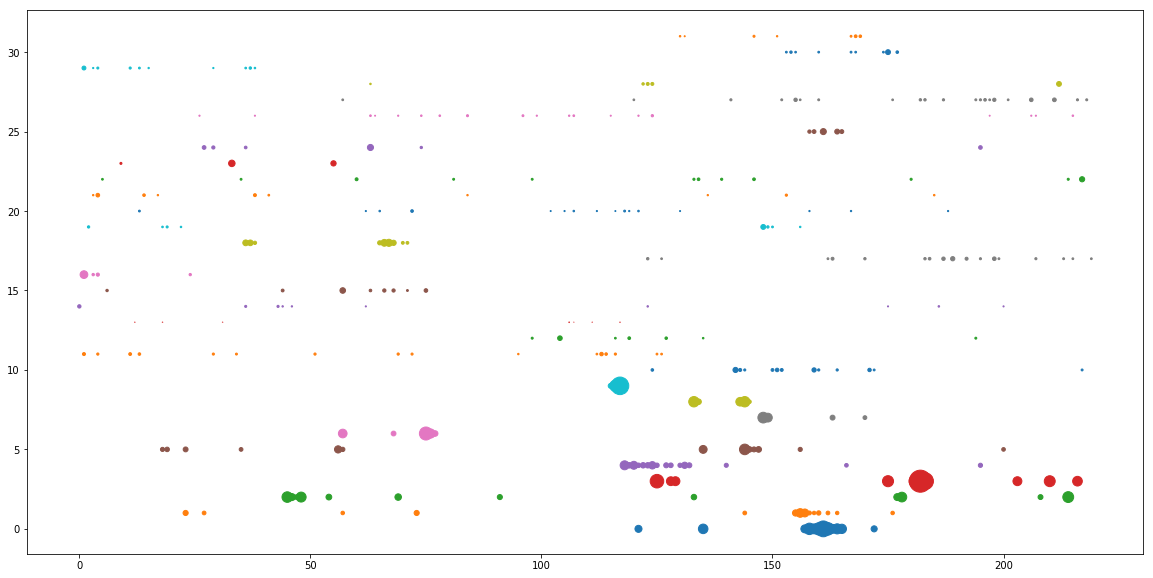

In [34]:
plt.figure(figsize=(20, 10))
for (i, e) in enumerate(events):
    draw_event(e, i, df_tf, df_occur)
# plt.xticks(range(0, 230), all_date)
plt.xticks(list(range(0, 230, 7)), [aall_date[i] for i in range(0, 230, 7)])
plt.yticks(range(0, 32), events, fontproperties=font)

plt.grid()
plt.show()

In [35]:
# each event with tfdf of related people
event_people_dict = {}
for event in events:
    event_data = data_containing_keyword(event, data)
    # event_data[0]
    name_times_of_date = {}
    for date in all_date:
        oneday_data = list(filter(lambda data: data['date']==date, event_data))
        oneday_dict = [news['cutted_dict'] for news in oneday_data]
        current_word_dict = merge_one_day_news_dict(oneday_dict, 'wt', divide=len(oneday_data))
        possible_name = first_n_words(current_word_dict, 10000, 3, 3)
        name_times_of_date[date]= list(filter(lambda x: x[0] in names, possible_name))

    all_names = set([name for name_list in name_times_of_date.values() for (name, times) in name_list])
    event_people_dict[event] = {name: [dict(name_times_of_date[date]).get(name, 0) for date in all_date] for name in all_names}
    
# with open('../data/event_people_dict.json', 'w', encoding='utf-8') as j:
#     json.dump(event_people_dict, j)

In [36]:
pd.DataFrame(event_people_dict).T.head(3)

,丁允恭,丁守中,何孟樺,何志偉,何瑞英,余登發,侯友宜,劉世芳,劉奕霆,劉曉玫,...,高思博,高育仁,魏明谷,黃信介,黃偉哲,黃國昌,黃士修,黃敏惠,黃瀞瑩,黃韋鈞
九二共識,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,NaN,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
兩岸關係,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 2.5, 0, 0, 2.0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
轉型正義,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN


In [37]:
people_tfdf_dict = {name: list(get_tfdf(name, df_tf, df_occur)) for name in names}

In [38]:
pd.DataFrame(people_tfdf_dict, index=aall_date).T.head(4)

,03-05,03-04,03-03,03-02,03-01,02-28,02-27,02-26,02-25,02-24,...,08-07,08-06,08-05,08-04,08-03,08-02,08-01,07-31,07-30,07-29
柯文哲,0.001233,0.000108,0.000627,0.000330,0.001029,0.000108,0.000314,0.000103,0.001411,0.001548,...,0.000000,0.001619,0.000863,0.001420,0.004383,0.000102,0.000962,0.000172,0.000911,0.001422
韓國瑜,0.000000,0.000000,0.000018,0.000002,0.000000,0.000015,0.000000,0.000000,0.000000,0.000000,...,0.001290,0.003691,0.000411,0.001053,0.001534,0.000376,0.000449,0.001834,0.002368,0.004741
陳其邁,0.000197,0.000027,0.000006,0.000022,0.000028,0.000010,0.000000,0.000114,0.000024,0.000000,...,0.000308,0.000018,0.000005,0.000009,0.000000,0.000000,0.000000,0.000019,0.000003,0.000000
蔡英文,0.001987,0.000548,0.000940,0.000289,0.000245,0.000023,0.001106,0.000257,0.000598,0.000124,...,0.000771,0.000892,0.000062,0.000563,0.000865,0.000274,0.000695,0.000076,0.000101,0.000000


# Part III 視覺化呈現研究結果

In [41]:
# import packages
import math
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import clear_output
from datetime import datetime, timedelta
import json

#### Section I 政治事件網路聲量分析

In [42]:
def get_scatter_trace(points_x, points_y, points_size=10, trace_name='', line=False):
    if line:
        return go.Scatter(
            x = points_x,
            y = points_y,
            mode = 'lines',
            hoverinfo = 'x+y',
            name
            = trace_name,
            text = points_size,
            yaxis = 'y2',
            line = {
                "color": 'rgba(255, 166, 87, 0.4)'
            }
        )
    else:
        return go.Scatter(
            x = points_x,
            y = points_y,
            mode = 'markers' if not line else 'lines',
            marker = {
                'size': points_size
            },
            hoverinfo = 'text+name',
            name = trace_name,
            text = points_size
        )

In [43]:
events = json.loads(open('../data/event_tfdf_dict.json').read())

In [44]:
def sectionI_plot(ori_data, title=''):
    
    # data
    fig_data = []
    for index, name in enumerate(ori_data):
        x, y, size = [], [], []
        for date, tfdf_val in ori_data[name].items():
            x.append(datetime.strptime(date, "%Y-%m-%d"))
            y.append(len(ori_data) - index)
            size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
        fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='Event'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)
    display(py.iplot(fig, filename='bubble-event'))

In [45]:
sectionI_plot(events)

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

#### Section II 事件相關人聲量分析

In [ ]:
event_people_relation = json.loads(open('../data/event_people_dict.json').read())

In [ ]:
def sectionII_plot(event_name, ori_data, selector_widget, start_date='2018-06-07', title=''):
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    # data
    fig_data = []
    x, y, size = [], [], []
    for date, tfdf_val in events[event_name].items():
        x.append(datetime.strptime(date, "%Y-%m-%d"))
        y.append(len(ori_data) + 1)
        size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
    fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=event_name))
        
    for index, name in enumerate(ori_data):
        x, y, size = [], [], []
        for day_index, tfdf_val in enumerate(ori_data[name]):
            if tfdf_val != 0:
                x.append(start_date + timedelta(days=day_index))
                y.append(len(ori_data) - index)
                size.append(max(math.log(round(tfdf_val, 2))*10,0)) ## constants need change
        fig_data.append(get_scatter_trace(x, y, points_size=size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='People'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)

    clear_output()
    display(selector_widget)
    display(py.iplot(fig, filename='event-people'))


In [ ]:
event_selector = widgets.Dropdown(
    options=list(events.keys()),
    description='政治事件：'
)
display(event_selector)

def event_change(change):
    top_10_related_people = dict(sorted(event_people_relation[change['new']].items(), key=lambda x: sum(x[1]), reverse=True)[:10])
    sectionII_plot(change['new'], top_10_related_people, event_selector, title=change['new'])

event_change({'new': list(events.keys())[0]})
    
event_selector.observe(event_change, names='value')

#### Section III 人物聲量與事件疊圖分析

In [ ]:
people = json.loads(open('../data/people_tfdf_dict.json').read())

In [ ]:
def sectionIII_plot(people_data, events_data, selector_widget, start_date='2018-06-07', title=''):
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    fig_data = []
    
    # people data
    x, y = [], []
    for day_index, value in enumerate(people_data['tfdf']):
        x.append(start_date + timedelta(days=day_index))
        y.append(value)
    fig_data.append(get_scatter_trace(x, y, line=True))
    
    # event data
    for index, name in enumerate(events_data):
        x, y, size = [], [], []
        for date, tfdf_val in events_data[name].items():
            x.append(datetime.strptime(date, "%Y-%m-%d"))
            y.append(len(events_data) - index)
            size.append(max(math.log(round(tfdf_val*10000, 2))*10, 0)) # constants need change
        fig_data.append(get_scatter_trace(x, y, size, trace_name=name))
        
    # layout
    fig_layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Date'
        ),
        yaxis=dict(
            title='Event'
        ),
        yaxis2=dict(
            title='People Reputation',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        )
    )

    fig = go.Figure(data=fig_data, layout=fig_layout)
    
    clear_output()
    display(selector_widget)
    display(py.iplot(fig, filename='person-events'))

In [ ]:
people_selector = widgets.Dropdown(
    options=list(people.keys()),
    description='政治人物：'
)
display(people_selector)

def people_change(change):
    sectionIII_plot({
        'name': change['new'],
        'tfdf': people[change['new']]
    }, events, people_selector, title='人物與事件聲量圖({})'.format(change['new']))

people_change({'new': list(people.keys())[0]})
    
people_selector.observe(people_change, names='value')


### Visualization
[Section I 政治事件網路聲量分析](https://plot.ly/~a136489/67)

[Section II 事件相關人聲量分析](https://plot.ly/~a136489/69/#/)

[Section III 人物聲量與事件疊圖分析](https://plot.ly/~a136489/71)
